##cài đặt thư viện 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install vncorenlp

     |████████████████████████████████| 2.6 MB 4.5 MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=ded13230c82bf1bf2c5ee7bd45b469719aa0c0b112c7a5d0acdd99e0d6afc5c7
  Stored in directory: /root/.cache/pip/wheels/0c/d8/f2/d28d97379b4f6479bf51247c8dfd57fa00932fa7a74b6aab29
Successfully built vncorenlp


In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2021-12-22 00:29:27--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M   160MB/s    in 0.2s    

2021-12-22 00:29:28 (160 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2021-12-22 00:29:28--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respon

##Data loader and pre-processing

In [ ]:
from vncorenlp import VnCoreNLP

vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
import pickle

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.graph_objects as go

from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam # - Works
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import text, sequence

pd.options.mode.chained_assignment = None
# load data
train = pd.read_csv("/content/drive/MyDrive/DOANMH/train.csv", index_col=False)
dev = pd.read_csv("/content/drive/MyDrive/DOANMH/dev.csv", index_col=False)
test = pd.read_csv("/content/drive/MyDrive/DOANMH/test.csv", index_col=False)


train.reset_index(drop=True)

print(train.head(10))
print('Phan biet')
print(test.head(10))
print('Phan biet')
print(dev.head(10))

                                           free_text  label_id
0  Em được làm fan cứng luôn rồi nè ❤️ reaction q...         0
1  Đúng là bọn mắt híp lò xo thụt :))) bên việt n...         2
2           Đậu Văn Cường giờ giống thằng sida hơn à         0
3  CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...         2
4  Từ lý thuyết đến thực hành là cả 1 câu chuyện ...         0
5                             Coronavirus is manmade         0
6                              Đố chúng m nhận ra ai         0
7                                  Lúp lúp như chó .         1
8                                                🥰🥰🥰         0
9  Thế mà mình nói mấy thằng bắc kì, bọn đó lại b...         2
Phan biet
                                           free_text  label_id
0                   Đừng cố biện minh =)))) choi lon         0
1                    Haizz. Nthe này thì dân khổ quá         1
2  the nay ma chi phat gay roi trat tu cong cong ...         0
3              Mua cho em hộp bcs mĩ sài cho 

In [ ]:
train

free_text  label_id
0      Em được làm fan cứng luôn rồi nè ❤️ reaction q...         0
1      Đúng là bọn mắt híp lò xo thụt :))) bên việt n...         2
2               Đậu Văn Cường giờ giống thằng sida hơn à         0
3      CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...         2
4      Từ lý thuyết đến thực hành là cả 1 câu chuyện ...         0
...                                                  ...       ...
24043                  Thả tim cho sự cống hiến của ngài         0
24044                                             Thua !         0
24045  Ở Việt Nam thì có khánh sky..hải ngoại có trần...         0
24046    1:22 ai lớp du chu cờ moo, Duyên dáng quá cô ơi         0
24047  Cụ này mắt mới cắt mý sao ta kkk đấy vnch đấy ...         0

[24048 rows x 2 columns]

Examples:
    Total: 24048
    CLEAR : 19886 (82.69% of total)

Examples:
    Total: 24048
    OFENSIVE: 1606 (6.68% of total)

Examples:
    Total: 24048
    HATE: 2556 (10.63% of total)



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



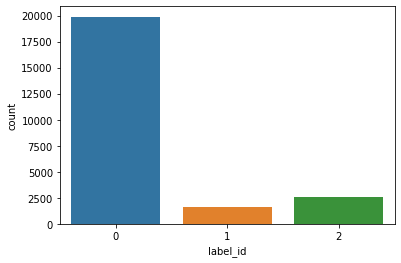

In [ ]:
clear, ofensive, hate = np.bincount(train['label_id'])
total = clear + ofensive + hate
print('Examples:\n    Total: {}\n    CLEAR : {} ({:.2f}% of total)\n'.format(
    total, clear, 100 * clear / total))
print('Examples:\n    Total: {}\n    OFENSIVE: {} ({:.2f}% of total)\n'.format(
    total, ofensive, 100 * ofensive / total))
print('Examples:\n    Total: {}\n    HATE: {} ({:.2f}% of total)\n'.format(
    total, hate, 100 * hate / total))

# sơ đồ data

sns.countplot('label_id',data=train)

##Tiền xử lí dữ liệu



In [ ]:
def get_score(model, X_train, X_text, y_train, y_test):
  model.fit(X,y_train)
  return model.score(X_test, y_test)
  
def get_stopwords_list(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return list(frozenset(stop_set))

In [ ]:
stopwords_path = "/content/drive/MyDrive/DOANMH/vietnamese-stopwords.txt"
stopwords = get_stopwords_list(stopwords_path)

In [ ]:
stopwords[0:10]

['như quả',
 'đến cùng',
 'thà',
 'như trước',
 'gây',
 'là cùng',
 'dưới',
 'suýt nữa',
 'ngoài này',
 'bằng nào']

In [ ]:
print(f"Total number of stopwords: {len(stopwords)}")

Total number of stopwords: 1942


In [ ]:
def remove_stopwords(corpus):
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stopword in stopwords:
            if stopword in tmp:
                tmp.remove(stopword)
        results.append(" ".join(tmp))
        
    return results

In [ ]:
 #tách emoji  
import re
import numpy as np
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)
# ko viết hoa
def text_lowercase(text):
    return text.lower()

# Remove numbers
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

# remove whitespace from text
def remove_whitespace(text):
    return  " ".join(text.split())

import string
string.punctuation
#loại bỏ các dấu chấm câu
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree





def preprocess(text, tokenized=True, lowercased=True, no_stw=True):
#    text = ViTokenizer.tokenize(text)
#    text = ' '.join(vncorenlp.tokenize(text)[0])
    if no_stw == True:
        text = remove_stopwords(text, stopwords)
    text = remove_emojis(text)
    text = re.sub('\[.*?\]', '', text) # remove square brackets
    text = re.sub(r'[^\w\s]','',text) # remove punctuation
    text = re.sub('\w*\d\w*', '', text) # remove words containing numbers
    text = re.sub(r'http\S+', '', text)
    text = text.lower() if lowercased else text
    if tokenized:
        pre_text = ""
        sentences = vncorenlp.tokenize(text)
        for sentence in sentences:
            pre_text += " ".join(sentence)
        text = pre_text
    return text

def pre_process_features(X, y, tokenized=True, lowercased=True, no_stw=True):
    X = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased, no_stw=no_stw) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx) 
    return X, y


In [ ]:
X_train = train['free_text']
y_train = train['label_id'].values

X_test = test['free_text']
y_test = test['label_id'].values

In [ ]:
X_train, y_train = pre_process_features(X_train, y_train, tokenized=True, lowercased = True, no_stw=False)
X_test, y_test = pre_process_features(X_test, y_test, tokenized=True, lowercased = True, no_stw=False)

In [ ]:
X_train

['em được làm fan cứng luôn rồi nè reaction quá hay quá cute coi mấy giờ này quá hợp_lí',
 'đúng là bọn mắt híp lò_xo thụt bên việt_nam t cái này ra cách đây năm r và bọn t gọi là cái l',
 'đậu văn cường giờ giống thằng sida hơn à',
 'côn_đồ cục_súc vô_nhân tính đề nghi vn nhà_nước vn ban thưởng',
 'từ lý_thuyết đến thực_hành là cả câu_chuyện dài',
 'coronavirus is manmade',
 'đố chúng m nhận ra ai',
 'lúp lúp như chó',
 '',
 'thế_mà mình nói mấy thằng bắc kì bọn đó lại bâu vô nói mình phân biệtd',
 'được anh ưi lâu rồi không nghe phúc du rap',
 'cắt cho trẻ trâu bớt thui mà',
 'nghe rất vô_lí nhưng cực_kì thuyết_phục',
 'chán ghê hong có pé mới máu được hâhha',
 'sao t gửi đc bây',
 'thế đấy làm j bọn nó bọn nó có quyền nên làm j chả được v',
 'loại này cho dựa cột thôi chứ độ_thế_nào',
 'thuong wa di',
 'dạy bơi cho cá bơi thì đương_nhiên nó bơi được vì nó là cá làm_sao cho nó sống được mới là điều người_dân đang quan_tâm',
 'ủa chứ bữa xin_lỗi khóc tế om xòm mà giờ chửi nữa rồi bó_t

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
import plotly.express as px
 
wc = WordCloud(height=400, width=600,
               background_color='white').generate_from_text(' '.join(X_train))
px.imshow(wc)



In [ ]:
len(X_train)

24048

## Mã hóa TfidfVectorizer

In [ ]:
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
#encoder = TfidfVectorizer(max_features= 5000, ngram_range =(1,1))
#encoder.fit(X_train)
#X_train_encoded = encoder.transform(X_train)
#X_test_encoded = encoder.transform(X_test)

#Mã hóa CountVectorizer




In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
encoder = CountVectorizer(ngram_range =(1,1))
encoder.fit(X_train)
X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [ ]:
encoder.vocabulary_

{'em': 3571,
 'được': 15970,
 'làm': 6476,
 'fan': 3625,
 'cứng': 2826,
 'luôn': 6411,
 'rồi': 10888,
 'nè': 9368,
 'reaction': 10625,
 'quá': 10403,
 'hay': 4348,
 'cute': 2274,
 'coi': 2117,
 'mấy': 7659,
 'giờ': 4020,
 'này': 9341,
 'hợp_lí': 5254,
 'đúng': 15895,
 'là': 6467,
 'bọn': 1066,
 'mắt': 7695,
 'híp': 4917,
 'lò_xo': 6732,
 'thụt': 12461,
 'bên': 695,
 'việt_nam': 14138,
 'cái': 2355,
 'ra': 10575,
 'cách': 2348,
 'đây': 15771,
 'năm': 9466,
 'và': 14244,
 'gọi': 4232,
 'đậu': 16095,
 'văn': 14379,
 'cường': 2604,
 'giống': 4010,
 'thằng': 12352,
 'sida': 11102,
 'hơn': 4982,
 'côn_đồ': 2454,
 'cục_súc': 2802,
 'vô_nhân': 14342,
 'tính': 13478,
 'đề': 16197,
 'nghi': 7987,
 'vn': 14166,
 'nhà_nước': 8887,
 'ban': 288,
 'thưởng': 12227,
 'từ': 13825,
 'lý_thuyết': 6786,
 'đến': 16189,
 'thực_hành': 12495,
 'cả': 2623,
 'câu_chuyện': 2387,
 'dài': 3231,
 'coronavirus': 2199,
 'is': 5344,
 'manmade': 7145,
 'đố': 16262,
 'chúng': 1713,
 'nhận': 9087,
 'ai': 69,
 'lúp': 6779,

In [ ]:
X_test_encoded

<6680x16641 sparse matrix of type '<class 'numpy.int64'>'
	with 56438 stored elements in Compressed Sparse Row format>

In [ ]:
X_test_encoded.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
X_train_encoded.todense

<bound method spmatrix.todense of <24048x16641 sparse matrix of type '<class 'numpy.int64'>'
	with 209824 stored elements in Compressed Sparse Row format>>

## Huấn luyện mô hình 

#KNN 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train_encoded, y_train) 

KNeighborsClassifier(n_neighbors=1)

In [ ]:
y_pred = model.predict(X_test_encoded)
import pandas as pd
d = {'Commet': X_test, 'Nhãn': y_pred}
df = pd.DataFrame(data=d)
df

Commet  Nhãn
0                            đừng cố biện_minh choi lon     0
1                        haizz nthe này thì dân khổ quá     1
2     the nay ma chi phat gay roi trat tu cong_cong ...     0
3                     mua cho em hộp bcs mĩ sài cho oai     1
4                                             coin card     0
...                                                 ...   ...
6675                 nghe cũng được nhưng vẫn cày views     0
6676  pha team up căng cực đến từ vị_trí ông chủ đầm...     0
6677  thanh nhường sao m đọc đc cmt của t thế tiên_sư m     0
6678  đúng rồi nhìn có ria mép với mặt giống đàn_ông...     0
6679  chưa chắc mỹ bị nhiễm virus corona vũ hán của ...     0

[6680 rows x 2 columns]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
cmNB = confusion_matrix(y_test, y_pred)
print(cmNB)
###Accuracy
print("Accuracy: {}".format(accuracy_score(y_test,y_pred)))
###F1-score
print('F1-macro score: {}'.format(f1_score(y_test, y_pred, average='macro')*100))
###precision_score
print("Precision score: {}".format(precision_score(y_test, y_pred, average='macro')))
###recall_score
print("Recall score: {}".format(recall_score(y_test, y_pred, average='macro')))





[[5257  213   78]
 [ 309  111   24]
 [ 501   89   98]]
Accuracy: 0.8182634730538922
F1-macro score: 46.165755877692376
Precision score: 0.5417519951076312
Recall score: 0.4466635088837097


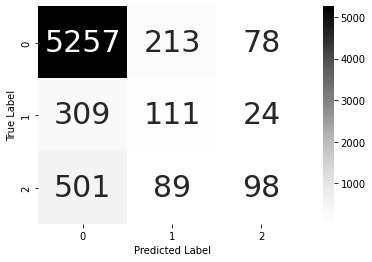

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

sn.heatmap(cmNB, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#Naive Bayes

In [ ]:
y_train

array([0, 2, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB.fit(X_train_encoded, y_train) 

MultinomialNB()

In [ ]:
y_pred_NB = NB.predict(X_test_encoded)
import pandas as pd
d = {'Commet': X_test, 'Nhãn': y_pred}
df = pd.DataFrame(data=d)
df

Commet  Nhãn
0                            đừng cố biện_minh choi lon     0
1                        haizz nthe này thì dân khổ quá     1
2     the nay ma chi phat gay roi trat tu cong_cong ...     0
3                     mua cho em hộp bcs mĩ sài cho oai     1
4                                             coin card     0
...                                                 ...   ...
6675                 nghe cũng được nhưng vẫn cày views     0
6676  pha team up căng cực đến từ vị_trí ông chủ đầm...     0
6677  thanh nhường sao m đọc đc cmt của t thế tiên_sư m     0
6678  đúng rồi nhìn có ria mép với mặt giống đàn_ông...     0
6679  chưa chắc mỹ bị nhiễm virus corona vũ hán của ...     0

[6680 rows x 2 columns]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

###Accuracy
print("Accuracy: {}".format(accuracy_score(y_test,y_pred_NB)*100))
###F1-score
print('F1-macro score: {}'.format(f1_score(y_test, y_pred_NB, average='macro')*100))
###precision_score
print("Precision score: {}".format(precision_score(y_test, y_pred_NB, average='macro')*100))
###recall_score
print("Recall score: {}".format(recall_score(y_test, y_pred_NB, average='macro')*100))

cmNB = confusion_matrix(y_test, y_pred_NB)



Accuracy: 86.00299401197606
F1-macro score: 53.75741860455287
Precision score: 67.61765108778222
Recall score: 51.2328403964401


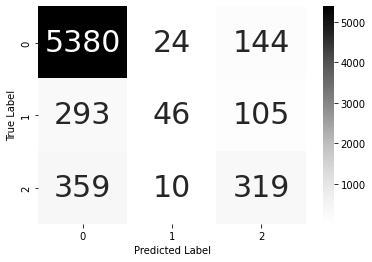

In [ ]:
import matplotlib.pyplot as plt


sn.heatmap(cmNB, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Decision tree



In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
DT = DecisionTreeClassifier(random_state=0,max_depth=2)
DT.fit(X_train_encoded, y_train)

DecisionTreeClassifier(max_depth=2, random_state=0)

In [ ]:
y_pred_DT = model.predict(X_test_encoded)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[5257  213   78]
 [ 309  111   24]
 [ 501   89   98]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



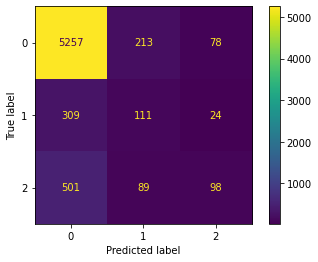

In [ ]:
plot_confusion_matrix(model, X_test_encoded,y_test)

In [ ]:

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

###Accuracy
print("Accuracy: {}".format(accuracy_score(y_test,y_pred_DT)))
###F1-score
print('F1-macro score: {}'.format(f1_score(y_test, y_pred_DT, average='macro')))
###precision_score
print("Precision score: {}".format(precision_score(y_test, y_pred_DT, average='macro')))
###recall_score
print("Recall score: {}".format(recall_score(y_test, y_pred_DT, average='macro')))

cmDST = confusion_matrix(y_test, y_pred_DT)


Accuracy: 0.8182634730538922
F1-macro score: 0.46165755877692377
Precision score: 0.5417519951076312
Recall score: 0.4466635088837097


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



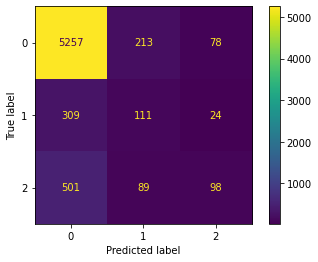

In [ ]:
plot_confusion_matrix(model, X_test_encoded,y_test)

#SVM

In [ ]:
from sklearn import svm
SVM = svm.SVC(kernel='linear', C=1, random_state=42)
SVM.fit(X_train_encoded, y_train)

SVC(C=1, kernel='linear', random_state=42)

In [ ]:
y_pred_SVM = SVM.predict(X_test_encoded)

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

###Accuracy
print("Accuracy: {}".format(accuracy_score(y_test,y_pred_SVM)*100))
###F1-score
print('F1-macro score: {}'.format(f1_score(y_test, y_pred_SVM, average='macro')*100))
###precision_score
print("Precision score: {}".format(precision_score(y_test, y_pred_SVM, average='macro')*100))
###recall_score
print("Recall score: {}".format(recall_score(y_test, y_pred_SVM, average='macro')*100))

cmDST = confusion_matrix(y_test, y_pred_SVM)


Accuracy: 86.30239520958084
F1-macro score: 59.75553172990553
Precision score: 66.07325984342114
Recall score: 56.045343288493974


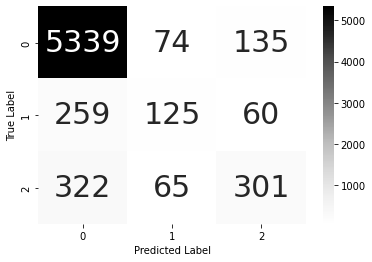

In [ ]:
import matplotlib.pyplot as plt


sn.heatmap(cmDST, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
RF = RandomForestClassifier(n_estimators=100)
RF.fit(X_train_encoded, y_train)

RandomForestClassifier()

In [ ]:
y_pred_RF = RF.predict(X_test_encoded)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

###Accuracy
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_RF)*100))
###F1-score
print('F1-macro score: {}'.format(f1_score(y_test, y_pred_RF, average='macro')*100))
###precision_score
print("Precision score: {}".format(precision_score(y_test, y_pred_RF, average='macro')*100))
###recall_score
print("Recall score: {}".format(recall_score(y_test, y_pred_RF, average='macro')*100))

cmRF = confusion_matrix(y_test, y_pred_RF)

Accuracy: 85.43413173652694
F1-macro score: 54.307098619164975
Precision score: 66.09631019387118
Recall score: 49.972281284319145


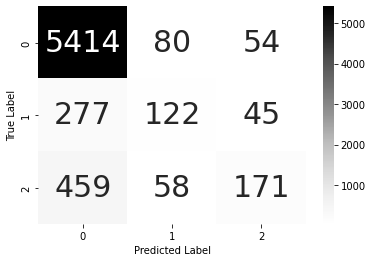

In [ ]:
import matplotlib.pyplot as plt


sn.heatmap(cmRF, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

##LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=2.0)
LR.fit(X_train_encoded, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=2.0)

In [ ]:
y_pred_LR=LR.predict(X_test_encoded)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

###Accuracy
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_LR)*100))
###F1-score
print('F1-macro score: {}'.format(f1_score(y_test, y_pred_LR, average='macro')*100))
###precision_score
print("Precision score: {}".format(precision_score(y_test, y_pred_LR, average='macro')*100))
###recall_score
print("Recall score: {}".format(recall_score(y_test, y_pred_LR, average='macro')*100))

cmLR = confusion_matrix(y_test, y_pred_LR)

Accuracy: 86.58682634730539
F1-macro score: 60.254343584060464
Precision score: 67.49717905926435
Recall score: 56.32346131530838


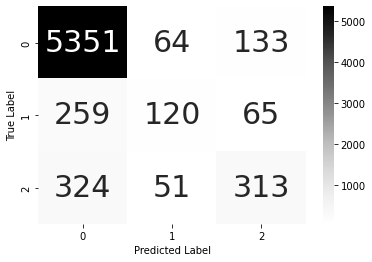

In [ ]:
import matplotlib.pyplot as plt


sn.heatmap(cmLR, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#Phân tích lỗi 

In [ ]:
y_test

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
error_indexes = []
for i in range(0, len(y_test)):
  if y_test[i] != y_pred[i]:
    error_indexes.append(i)

In [ ]:
error_indexes

[3,
 4,
 11,
 19,
 22,
 23,
 34,
 38,
 42,
 60,
 64,
 65,
 69,
 75,
 76,
 109,
 111,
 113,
 131,
 136,
 138,
 140,
 142,
 143,
 144,
 159,
 162,
 172,
 175,
 178,
 181,
 185,
 196,
 197,
 198,
 204,
 207,
 214,
 216,
 220,
 226,
 227,
 230,
 231,
 234,
 235,
 248,
 254,
 259,
 267,
 271,
 272,
 273,
 278,
 280,
 285,
 293,
 304,
 305,
 309,
 316,
 320,
 330,
 333,
 335,
 338,
 360,
 370,
 371,
 373,
 384,
 387,
 404,
 419,
 424,
 425,
 426,
 432,
 434,
 439,
 460,
 473,
 475,
 479,
 483,
 485,
 491,
 495,
 499,
 504,
 507,
 513,
 516,
 522,
 527,
 528,
 529,
 530,
 552,
 558,
 563,
 566,
 571,
 589,
 593,
 599,
 603,
 604,
 605,
 606,
 607,
 611,
 613,
 614,
 616,
 622,
 629,
 634,
 637,
 653,
 658,
 663,
 672,
 676,
 683,
 684,
 686,
 704,
 705,
 707,
 708,
 709,
 714,
 717,
 729,
 730,
 736,
 739,
 742,
 750,
 751,
 763,
 767,
 772,
 778,
 787,
 803,
 807,
 831,
 834,
 835,
 837,
 842,
 843,
 844,
 847,
 854,
 859,
 865,
 868,
 871,
 872,
 894,
 896,
 915,
 921,
 933,
 934,
 936,
 93

In [ ]:
X_test = np.array(X_test)

In [ ]:
X_test

array(['đừng cố biện_minh choi lon', 'haizz nthe này thì dân khổ quá',
       'the nay ma chi phat gay roi trat tu cong_cong thoi a dung la dan_minh',
       ..., 'thanh nhường sao m đọc đc cmt của t thế tiên_sư m',
       'đúng rồi nhìn có ria mép với mặt giống đàn_ông vcl v',
       'chưa chắc mỹ bị nhiễm virus corona vũ hán của virus trung cộng nhiều hơn mỹ'],
      dtype='<U1729')

In [ ]:
X_test_temp = X_test

In [ ]:
for i in error_indexes:
  print('Comment: {} - True label: {} - Predicted label: {}'.format(X_test_temp[i],y_test[i],y_pred[i]))

Comment: mua cho em hộp bcs mĩ sài cho oai - True label: 0 - Predicted label: 1
Comment: coin card - True label: 1 - Predicted label: 0
Comment: thầy trêu ổng cho lắm vào bị thế_là đúng r - True label: 0 - Predicted label: 1
Comment: sét đánh chết tao đi - True label: 0 - Predicted label: 1
Comment: y page này ad nó kiến_thức uyên sâu lắm từ xây_dựng tài_chính y_tế cái j n cũng am_hiểu ngu_dốt nhiệt_tình phá_hoại k sai bh - True label: 2 - Predicted label: 0
Comment: đề_nghị đến phà vài hơi vào mẹt tk này để nó đi cách_ly thế_giới hẳn đi - True label: 2 - Predicted label: 0
Comment: k nói thì tự kiêunói thì lại tự_ái chứ í thức thế ai mà chịu nổi - True label: 1 - Predicted label: 2
Comment: hanh viet hết cái bọn cực_kì thuyết_phục bây_giờ lại đến bọn ở nhà giúp mẹ giúp cha xàm lol như nhau cả thôi - True label: 2 - Predicted label: 0
Comment: nguyễn_thị thuỷ chó con chứ dúi đâu ra - True label: 0 - Predicted label: 2
Comment: một phút bóc đồng_bằng cả đời bóc cức - True label: 1 - Pre

## Viết vài câu thử nghiệm 

In [ ]:
REAL_LABEL = {
    0: "CLEAR (SẠCH)",
    1: "OFFENSIVE (XÚC PHẠM)",
    2: "HATE (THÙ GHÉT)"
}

In [ ]:
print("Nhập một comment để dự đoán: ")
input_text = input()

input_encoded = encoder.transform([input_text])
label = model.predict(input_encoded)

print("Nhãn của câu comment là: {}".format(REAL_LABEL[label[0]]))

Nhập một comment để dự đoán: 
m ngu như koakoa xem
Nhãn của câu comment là: CLEAR (SẠCH)
